## CycleGAN で PyTorch実装を学ぶ
- Reference
  - https://github.com/eriklindernoren/PyTorch-GAN
  - https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/cyclegan
  

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import itertools

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [4]:
# for model

import torch.nn as nn
import torch.nn.functional as F
import torch

In [5]:
# for datasets

import glob
import random
#import os
#import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

In [6]:
#torch.__version__

In [7]:
DATA_DIR_PATH = '/content/drive/My Drive/project/ML/pytorch-gan/data'

OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '07_out')

In [8]:
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [9]:
cuda = True if torch.cuda.is_available() else False

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64

        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]

        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2

            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]

            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [
                nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)
            ]

            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))

            layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [13]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [14]:
class CycleGAN:
    def __init__(self, data_loader, val_data_loader, input_shape, n_residual_blocks=9):
        self.history = pd.DataFrame({}, columns=[
            'epoch', 'batche_i',
            'loss_D', 'loss_G', 'loss_GAN', 'loss_cycle', 'loss_identity'
            'elapsed_time'])

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.G_AB_name = 'G_AB'
        self.G_BA_name = 'G_BA'
        self.train_cnt = 0

        self.data_loader = data_loader
        self.val_data_loader = val_data_loader
        self.input_shape = input_shape
        self.n_residual_blocks = n_residual_blocks
        self.lambda_cyc = 10.0
        self.lambda_id = 5.0

        # Losses
        self.criterion_GAN = torch.nn.MSELoss()
        self.criterion_cycle = torch.nn.L1Loss()
        self.criterion_identity = torch.nn.L1Loss()

        # Initialize generator and discriminator
        self.G_AB = GeneratorResNet(self.input_shape, self.n_residual_blocks)
        self.G_BA = GeneratorResNet(self.input_shape, self.n_residual_blocks)
        self.D_A = Discriminator(self.input_shape)
        self.D_B = Discriminator(self.input_shape)

        if cuda:
            self.G_AB = self.G_AB.cuda()
            self.G_BA = self.G_BA.cuda()
            self.D_A = self.D_A.cuda()
            self.D_B = self.D_B.cuda()
            self.criterion_GAN.cuda()
            self.criterion_cycle.cuda()
            self.criterion_identity.cuda()

        # if opt.epoch != 0:
        #     # Load pretrained models
        #     G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (self.dataset_name, self.epoch)))
        #     G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (self.dataset_name, self.epoch)))
        #     D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (self.dataset_name, self.epoch)))
        #     D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (self.dataset_name, self.epoch)))
        # Initialize weights
        self.G_AB.apply(weights_init_normal)
        self.G_BA.apply(weights_init_normal)
        self.D_A.apply(weights_init_normal)
        self.D_B.apply(weights_init_normal)

        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999

        # Optimizers
        self.optimizer_G = torch.optim.Adam(
            itertools.chain(self.G_AB.parameters(), self.G_BA.parameters()), lr=self.lr, betas=(self.b1, self.b2)
        )
        self.optimizer_D_A = torch.optim.Adam(self.D_A.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        self.optimizer_D_B = torch.optim.Adam(self.D_B.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        self.Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

        # Buffers of previously generated samples
        self.fake_A_buffer = ReplayBuffer()
        self.fake_B_buffer = ReplayBuffer()

    def train(self, n_epochs, decay_epoch, sample_interval=-1):
        epoch = 0

        self.train_cnt += 1

        print(datetime.datetime.now().isoformat(), 'Start', self.train_cnt)

        start_time = datetime.datetime.now()

        step_cnt = 1

        # Learning rate update schedulers
        lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
        )
        lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
        )
        lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
        )

        for epoch_i in range(epoch+1, n_epochs+1):

            for batch_i, batch in enumerate(self.data_loader, 1):
                # Set model input
                real_A = Variable(batch["A"].type(self.Tensor))
                real_B = Variable(batch["B"].type(self.Tensor))

                # Adversarial ground truths
                valid = Variable(self.Tensor(np.ones((real_A.size(0), *self.D_A.output_shape))), requires_grad=False)
                fake  = Variable(self.Tensor(np.zeros((real_A.size(0), *self.D_A.output_shape))), requires_grad=False)

                # Train Generator
                self.G_AB.train()
                self.G_BA.train()

                self.optimizer_G.zero_grad()

                # Identity loss
                loss_id_A = self.criterion_identity(self.G_BA(real_A), real_A)
                loss_id_B = self.criterion_identity(self.G_AB(real_B), real_B)

                loss_identity = (loss_id_A + loss_id_B) / 2

                # GAN loss
                fake_B = self.G_AB(real_A)
                loss_GAN_AB = self.criterion_GAN(self.D_B(fake_B), valid)
                fake_A = self.G_BA(real_B)
                loss_GAN_BA = self.criterion_GAN(self.D_A(fake_A), valid)

                loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

                # Cycle loss
                recov_A = self.G_BA(fake_B)
                loss_cycle_A = self.criterion_cycle(recov_A, real_A)
                recov_B = self.G_AB(fake_A)
                loss_cycle_B = self.criterion_cycle(recov_B, real_B)

                loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

                # Total loss
                loss_G = loss_GAN + self.lambda_cyc * loss_cycle + self.lambda_id * loss_identity

                loss_G.backward()
                self.optimizer_G.step()

                # Train Discriminator A
                self.optimizer_D_A.zero_grad()

                # Real loss
                loss_real = self.criterion_GAN(self.D_A(real_A), valid)
                # Fake loss (on batch of previously generated samples)
                fake_A_ = self.fake_A_buffer.push_and_pop(fake_A)
                loss_fake = self.criterion_GAN(self.D_A(fake_A_.detach()), fake)
                # Total loss
                loss_D_A = (loss_real + loss_fake) / 2

                loss_D_A.backward()
                self.optimizer_D_A.step()

                # Train Discriminator B
                self.optimizer_D_B.zero_grad()

                # Real loss
                loss_real = self.criterion_GAN(self.D_B(real_B), valid)
                # Fake loss (on batch of previously generated samples)
                fake_B_ = self.fake_B_buffer.push_and_pop(fake_B)
                loss_fake = self.criterion_GAN(self.D_B(fake_B_.detach()), fake)
                # Total loss
                loss_D_B = (loss_real + loss_fake) / 2

                loss_D_B.backward()
                self.optimizer_D_B.step()

                loss_D = (loss_D_A + loss_D_B) / 2

                # Log Progress
                batches_done = epoch_i * len(self.data_loader) + batch_i
                elapsed_time = datetime.datetime.now() - start_time

                self.history = self.history.append({
                    'epoch': epoch_i,
                    'batch_i': batch_i,
                    'loss_D':loss_D.item(),
                    'loss_G': loss_G.item(),
                    'loss_GAN': loss_GAN.item(),
                    'loss_cycle': loss_cycle.item(),
                    'loss_identity': loss_identity.item(),
                    'elapsed_time': elapsed_time
                }, ignore_index=True)


                if sample_interval > 0 and step_cnt % sample_interval == 0:
                    print(
                        '[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] %s'
                        % (
                            epoch_i,
                            n_epochs,
                            batch_i,
                            len(self.data_loader),
                            loss_D.item(),
                            loss_G.item(),
                            loss_GAN.item(),
                            loss_cycle.item(),
                            loss_identity.item(),
                            elapsed_time
                        )
                    )
                    # sys.stdout.write(
                    #     "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                    #     % (
                    #         epoch,
                    #         opt.n_epochs,
                    #         i,
                    #         len(dataloader),
                    #         loss_D.item(),
                    #         loss_G.item(),
                    #         loss_GAN.item(),
                    #         loss_cycle.item(),
                    #         loss_identity.item(),
                    #         time_left,
                    #     )
                    # )

                    self.sample_images(epoch, batch_i)

                step_cnt += 1

            # Update learning rates
            lr_scheduler_G.step()
            lr_scheduler_D_A.step()
            lr_scheduler_D_B.step()

        print(datetime.datetime.now().isoformat(), 'End')

    def sample_images(self, epoch, batch_i, n_row=5):
        """Saves a generated sample from the test set"""
        imgs = next(iter(self.val_data_loader))
        self.G_AB.eval()
        self.G_BA.eval()
        real_A = Variable(imgs["A"].type(self.Tensor))
        fake_B = self.G_AB(real_A)
        real_B = Variable(imgs["B"].type(self.Tensor))
        fake_A = self.G_BA(real_B)

        # Arange images along x-axis
        real_A = make_grid(real_A, nrow=n_row, normalize=True)
        real_B = make_grid(real_B, nrow=n_row, normalize=True)
        fake_A = make_grid(fake_A, nrow=n_row, normalize=True)
        fake_B = make_grid(fake_B, nrow=n_row, normalize=True)

        # Arange images along y-axis
        image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
        file_name = os.path.join(self.img_save_dir, '{}_{}_{}.png'.format(self.train_cnt, epoch, batch_i))
        save_image(image_grid, file_name, normalize=False)

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['loss_D', 'loss_G']
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_state_dict(self.G_AB, self.G_AB_name, file_suffix)
        self.save_state_dict(self.G_BA, self.G_BA_name, file_suffix)

    def save_state_dict(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_model_file_name(model_name, file_suffix))
        torch.save(model.state_dict(), file_path)
        print('Model saved.', model_name)

    def _create_model_file_name(self, model_name, suffix=None):
        processor = 'gpu' if cuda else 'cpu'

        if suffix:
            return '{}_{}_{}.pth'.format(model_name, processor, suffix)
        else:
            return '{}_{}.pth'.format(model_name, processor)

In [15]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%s/A" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%s/B" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [16]:
# Configure data loader
dataset_name = 'apple2orange'
img_root_path = os.path.join(DATA_DIR_PATH, dataset_name)
channels = 3
img_height = 256
img_width = 256
input_shape = (channels, img_height, img_width)
batch_size = 1
n_cpu = 8

# Image transformations
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
dataloader = DataLoader(
    ImageDataset(img_root_path, transforms_=transforms_, unaligned=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

# Test data loader
val_dataloader = DataLoader(
    ImageDataset(img_root_path, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=1,
)

In [17]:
n_epochs = 1
decay_epoch = 0
sample_interval = 50

gan = CycleGAN(dataloader, val_dataloader, input_shape)
gan.train(n_epochs, decay_epoch, sample_interval)

2020-10-21T01:05:41.276667 Start 1
[Epoch 1/1] [Batch 50/1019] [D loss: 0.482092] [G loss: 4.747176, adv: 0.387521, cycle: 0.299381, identity: 0.273168] 0:00:13.010547
[Epoch 1/1] [Batch 100/1019] [D loss: 0.315026] [G loss: 5.101553, adv: 0.328433, cycle: 0.328788, identity: 0.297048] 0:00:36.735435
[Epoch 1/1] [Batch 150/1019] [D loss: 0.413143] [G loss: 5.327428, adv: 0.443687, cycle: 0.334742, identity: 0.307264] 0:01:00.013153
[Epoch 1/1] [Batch 200/1019] [D loss: 0.265400] [G loss: 3.974485, adv: 0.394100, cycle: 0.248568, identity: 0.218942] 0:01:24.103086
[Epoch 1/1] [Batch 250/1019] [D loss: 0.258568] [G loss: 5.630082, adv: 0.499422, cycle: 0.356432, identity: 0.313269] 0:01:46.837612
[Epoch 1/1] [Batch 300/1019] [D loss: 0.181516] [G loss: 3.881083, adv: 0.598821, cycle: 0.220080, identity: 0.216293] 0:02:08.834552
[Epoch 1/1] [Batch 350/1019] [D loss: 0.290416] [G loss: 3.937154, adv: 0.366254, cycle: 0.245764, identity: 0.222651] 0:02:31.256000
[Epoch 1/1] [Batch 400/1019]

Model saved. G_AB
Model saved. G_BA


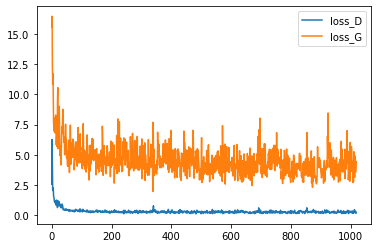

In [18]:
gan.plot_hisotry()

gan.save_models()